### Import libs and data

In [1]:
import nltk
# nltk.download("stopwords")
# nltk.download('vader_lexicon')

import pandas as pd
from string import punctuation
import matplotlib.pyplot as plt 

from nltk.corpus import stopwords
from nltk.corpus import sentiwordnet as swn
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [2]:
data = pd.read_csv(r'C:\Users\Achilles\PycharmProjects\data\FirstSkillsTraining\FST_NEW_IDs.csv', na_values=[''])
data[1:3].head()

,Unnamed: 0,date,start_time,end_time,duration,summary,number_listed,number_of_young_persons_attending,description,id
1,569,12/2/2020,11:00,13:00,2.0,Good session at boxing with Ollie.\r\nHe wasn'...,1,1,Ollie had a good session today. The instructor...,39
2,570,11/2/2020,15:00,17:00,2.0,Good session with Ryan. He seemed in a good mo...,1,1,Good session from Ryan. He really wanted to ba...,8


### Pre-processing

In [3]:
data.dropna(subset=['description'],inplace=True)
data['date']=pd.to_datetime(data['date'],dayfirst=True)
data['date'] = data['date'].dt.strftime('%Y/%m/%d')
data['description']=data['description'].apply(lambda text: text.replace("\n"," ").replace("&nbsp"," ").replace("\r"," "))

In [4]:
lemmatizer=WordNetLemmatizer()
sid=SentimentIntensityAnalyzer()
stop=stopwords.words("english")

In [5]:
data['sentiment_score'] = data['description'].apply(lambda text: sid.polarity_scores(str(text))['compound'])

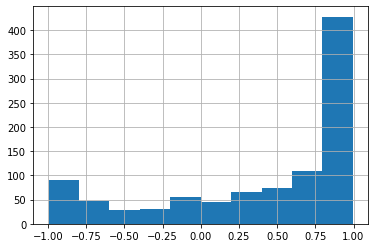

In [6]:
data.sentiment_score.hist()

In [41]:
def sentiment_names (row):
    if row['sentiment_score'] < -0.5 :
        return 'very negative'
    elif row['sentiment_score'] < -0.1:
        return 'negative'
    elif row['sentiment_score'] <= 0.1:
        return 'neutral'
    elif row['sentiment_score'] < 0.5:
        return 'positive'
    else:
        return 'very positive'

def duration (row):
   if row['duration'] < 1.5 :
      return 1
   if row['duration'] >= 1.5 and row['duration'] < 2.5:
      return 2
   if row['duration'] >= 2.5 and row['duration'] < 3.5:
      return 3
   if row['duration'] >= 3.5 and row['duration'] < 4.5:
      return 4
   if row['duration'] >= 4.5 and row['duration'] < 5.5:
      return 5
   if row['duration'] >= 5.5 and row['duration'] < 6.5:
      return 6
   else:
      return 7

In [42]:
data['duration_updated'] = data.apply (lambda row: duration(row), axis=1)  
data['sentiment'] = data.apply (lambda row: sentiment_names(row), axis=1)  

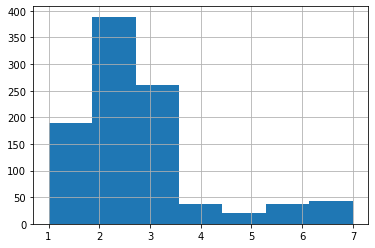

In [43]:
data.duration_updated.hist(bins=7)

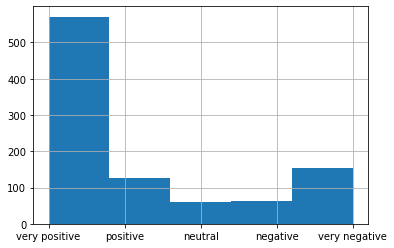

In [46]:
data.sort_values('sentiment_score', ascending=False).sentiment.hist(bins=5)

In [330]:
def select_participant_data(id):
    participant_data=data[data['id']==id].sort_values(by=['date'], axis=0, ascending=True)[['date', 
                                                                                     'description', 
                                                                                     'sentiment', 
                                                                                     'sentiment_score']]
    participant_data.columns=['Date', 'Description', 'Sentiment', 'Sentiment Score']
    return participant_data

In [331]:
def participant_sentiment_over_time(id):
    participant_data = select_participant_data(id)
    participant_data[['Date', 'Sentiment Score']].plot.bar()
    plt.ylabel('Sentiment Score', fontsize=10)
    plt.xlabel('Date', fontsize=10)
    plt.xticks(range(0, participant_data.shape[0]), participant_data.Date.values, rotation='vertical')
    plt.title('Sentiment Score over Time for ID: ' +str(id))
#     plt.show()

In [332]:
def participant_word_cloud(id):
    participant_data = select_participant_data(id)
    single_string = ' '.join(participant_data['Description'])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=250, height=180).generate(single_string)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud for ID#'+str(id))
    plt.show()

In [333]:
# display(select_participant_data(1))

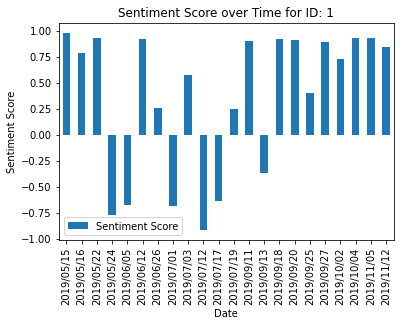

In [334]:
participant_sentiment_over_time(1)

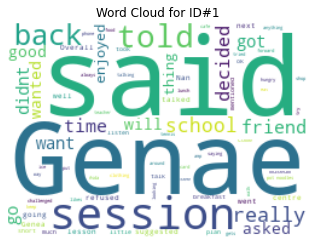

In [335]:
participant_word_cloud(1)

In [336]:
def overall_word_cloud(data):
    all_descriptions = ' '.join(data['description'])
    wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', width=250, height=180).generate(all_descriptions)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Word Cloud created from all descriptions')
    plt.show()

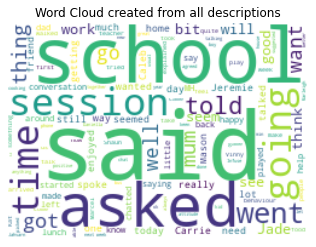

In [337]:
overall_word_cloud(data)

In [338]:
data.groupby(['sentiment']).count()[['date']].rename(columns={'date': 'count'}).reset_index(level=0)

,sentiment,count
0,negative,329
1,neutral,25
2,positive,279
3,very negative,50
4,very positive,292


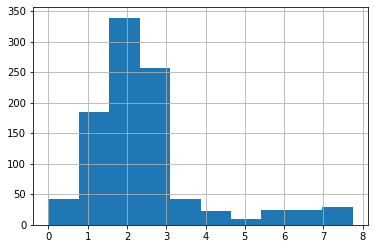

In [339]:
data.duration.hist()

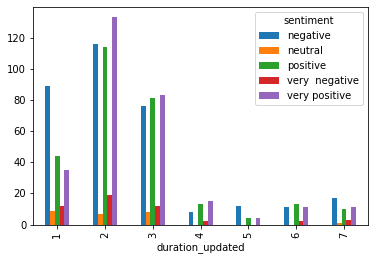

In [341]:
pd.pivot_table(data[['duration_updated', 'sentiment']], index='duration_updated', 
               columns='sentiment', aggfunc=len).plot(kind='bar')

In [388]:
agg_data = data[['sentiment', 'sentiment_score', 'duration_updated']].copy(deep=True)
agg_data['sessions_in_bin'] = agg_data['duration_updated'].astype('int')
agg_data['percentage_of_sessions'] = agg_data['duration_updated'].astype('int')
agg_data = agg_data.groupby(['duration_updated', 'sentiment']).agg({'sessions_in_bin': 'sum'}).reset_index()
agg_data['percentage_of_sessions'] = agg_data[
        ['duration_updated', 'sessions_in_bin']].groupby('duration_updated').apply(lambda x: round(100*x/float(x.sum()),2))
agg_data.head()

,duration_updated,sentiment,sessions_in_bin,percentage_of_sessions
0,1,negative,89,47.09
1,1,neutral,9,4.76
2,1,positive,44,23.28
3,1,very negative,12,6.35
4,1,very positive,35,18.52


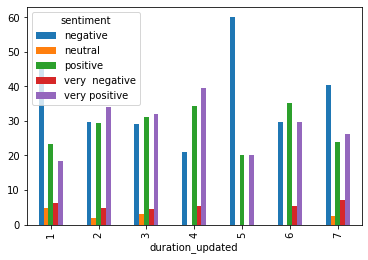

In [389]:
pd.pivot_table(agg_data[['duration_updated', 'percentage_of_sessions', 'sentiment']], index='duration_updated', 
               columns='sentiment', values='percentage_of_sessions').plot(kind='bar')

In [ ]:
# # for absenses we need to do the same but with the absent column present
# absent_agg_data = data[data['absent']==1][['sentiment', 'sentiment_score', 'duration_updated']].copy(deep=True)
# absent_agg_data['sessions_in_bin'] = absent_agg_data['duration_updated'].astype('int')
# absent_agg_data['percentage_of_sessions'] = absent_agg_data['duration_updated'].astype('int')
# absent_agg_data = absent_agg_data.groupby(['duration_updated', 'sentiment']).agg({'sessions_in_bin': 'sum'}).reset_index()
# absent_agg_data['percentage_of_sessions'] = absent_agg_data[
#         ['duration_updated', 'sessions_in_bin']].groupby('duration_updated').apply(lambda x: round(100*x/float(x.sum()),2))
# pd.pivot_table(agg_data[['duration_updated', 'percentage_of_sessions', 'sentiment']], index='duration_updated', 
#                columns='sentiment', values='percentage_of_sessions').plot(kind='bar')

In [395]:
agg_session_count_data = data[['sentiment', 'sentiment_score', 'duration_updated', 'id', 'date']].copy(deep=True)
agg_session_count_data = agg_session_count_data.sort_values(by=['id', 'date'], axis=0, ascending=True)
agg_session_count_data['session_count'] = agg_session_count_data.groupby(['id']).cumcount() + 1
agg_session_count_data.head()

,sentiment,sentiment_score,duration_updated,id,date,session_count
160,very positive,0.9819,3,1,2019/05/15,1
158,positive,0.7845,1,1,2019/05/16,2
152,very positive,0.9309,3,1,2019/05/22,3
148,negative,-0.7745,3,1,2019/05/24,4
141,negative,-0.6764,3,1,2019/06/05,5


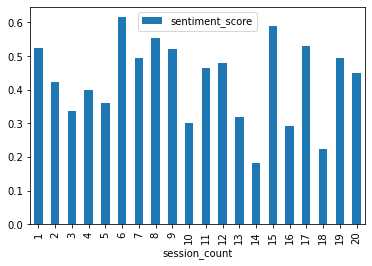

In [406]:
# agg_session_count_data[['sentiment_score', 'session_count']].groupby('session_count').mean().plot.bar()
agg_session_count_data[['sentiment_score', 'session_count']].groupby('session_count').mean()[:20].plot.bar()